This page demonstrates the current functionality of [PyRhodium.jl](https://github.com/davidanthoff/PyRhodium.jl), a julia wrapper around the [Rhodium](https://github.com/Project-Platypus/Rhodium) Python library for exploratory modelling and robust decision making.

## Defining the Model

Begin by importing the necessary packages.

In [1]:
using PyRhodium, Roots, Distributions, DataFrames, Random

Next, we define our model.  The model can be any julia function, with any number of keyword input arguments.  The names of the input arguments will become important later.  The model can also return any number of outputs.  For this example, we will use the [lake problem](https://github.com/OpenMORDM/OpenMORDM/wiki/Defining%20a%20Model):

In [2]:
function lake_problem(;pollution_limit=nothing,
         b = 0.42,       # decay rate for P in lake (0.42 = irreversible)
         q = 2.0,        # recycling exponent
         mean = 0.02,       # mean of natural inflows
         stdev = 0.001,      # standard deviation of natural inflows
         alpha = 0.4,        # utility from pollution
         delta = 0.98,       # future utility discount rate
         nsamples = 100) # monte carlo sampling of natural inflows)
    Pcrit = fzero(x -> x^q/(1+x^q) - b*x, 0.01, 1.5)
    nvars = length(pollution_limit)
    X = zeros(nvars)
    average_daily_P = zeros(nvars)
    reliability = 0.0

    d = LogNormal(log(mean^2 / sqrt(stdev^2 + mean^2)),sqrt(log(1.0 + stdev^2 / mean^2)))
    
    natural_inflows = zeros(nvars)
    
    for i in 1:nsamples
        X[1] = 0.0        
        
        rand!(d, natural_inflows)
        
        for t in 2:nvars
            X[t] = (1-b)*X[t-1] + X[t-1]^q/(1+X[t-1]^q) + pollution_limit[t] + natural_inflows[t]
            average_daily_P[t] += X[t]/nsamples
        end
    
        reliability += sum(X .< Pcrit)/(nsamples*nvars)
    end
      
    max_P = maximum(average_daily_P)
    utility = sum(alpha.*pollution_limit.*delta.^collect(1:nvars))
    intertia = sum(diff(pollution_limit) .> -0.02)/(nvars-1)    
    
    return max_P, utility, intertia, reliability
end

lake_problem (generic function with 1 method)

Next, we define a Rhodium model.  A Rhodium model provides additional annotations for the function above.  In particular, we will identify all parameters (inputs) and responses (outputs) of interest.

In [3]:
model = Model(lake_problem)
set_parameters!(model, [:pollution_limit, :b, :q, :mean, :stdev, :delta])
set_responses!(model, [:max_P => :MINIMIZE, :utility => :MAXIMIZE, :inertia => :MAXIMIZE, :reliability => :MAXIMIZE])

Parameter names must match the argument name in the julia function.  You can also define default values for parameters, but it will fall back to using any default values in the function definition.  Responses identify the model outputs.  In addition to providing a name for each response, you can also specify if the response is an objective to be minimized or maximized, or indicate the response is "informational" and should not be optimized.

Rhodium also supports constraints.  For example, we could define a constraint on reliability.  Note how the constraint is a valid Python expression that can reference any parameter or response.  You should in general try to keep each constraint simple, such as simple equality or inequality expressions, which will help improve the performance of the optimization algorithm.

In [4]:
set_constraints!(model, ["reliability >= 0.95"])

Or we could have an unconstrained problem, in which case we simply do not define any constraints:

In [5]:
set_constraints!(model, [])

At this point, the model is ready for use with Rhodium.

## Optimizing the Model

With the model defined, we can perform a variety of analyses within Rhodium.  First we will demonstrate optimizing the model.  Rhodium will attempt the optimize the responses you defined subject to any constraints by tweaking levers.  Levers are parameters that we can control when implementing a policy.  For the lake problem, we are controlling the amount of pollution released yearly into the lake.  Thus, we will define a lever for our `pollution_limit` parameter to be 100 values between 0.0 and 0.1.

In [6]:
collect(model.pyo.parameters)[1].__dict__

Dict{Any,Any} with 2 entries:
  "name"          => "pollution_limit"
  "default_value" => nothing

In [7]:
set_levers!(model, [RealLever("pollution_limit", 0.0, 0.1, length=100)])

Next, we call `optimize` to optimize the problem.  The optimization algorithm will iteratively adjust the levers while searching for an optimal policy.  If more than one response is defined, such as in this example, then typically many Pareto optimal responses can be found.  None of the identified Pareto optimal policies is better than any other; instead they form a tradeoff among the responses, some with better performance with respect to one or more responses but worse in others.  Running the optimization below, we should find many optimal policies:

In [8]:
# output = optimize(model, "NSGAII", 10_000)
# TODO 
output = optimize(model, "NSGAII", 1000)
println("Found $(length(output)) optimal policies!")

here
Found 100 optimal policies!


Here, `output` is a Rhodium data set containing one or more optimal policies.  We can reference specific policies by index, such as `output[5]`, or by searching for a policy with certain traits using the `find`, `find_min`, and `find_max` methods.  For example:

In [9]:
policy = output[5]
policy = findmax(output, :reliability)
policies = find(output, "utility > 0.5");

As demonstrated above, a Rhodium data set acts like a list with additional methods for querying data.  Each entry (aka policy) within the dataset is a julia [NamedTuple](https://github.com/blackrock/NamedTuples.jl) that has a field for each values. The field name corresponds to the name of the parameter or response we defined in the model.  For example, we can print information about a selected policy:

In [10]:
policy = named_tuple(findmax(output, :reliability))

println("Max Phosphorus in Lake: ", policy.max_P)
println("Utility:                ", policy.utility)
println("Inertia:                ", policy.inertia)
println("Reliability:            ", policy.reliability)

Max Phosphorus in Lake: 0.2668549539436689
Utility:                0.41426235415702384
Inertia:                0.797979797979798
Reliability:            1.0000000000000007


We can also use the `apply` method to perform calculations on the data.  The expression can reference any keys (the parameters and responses) that are defined in the policy.

Here, the `apply` method returns a list storing the sum of the yearly pollution limits for each policy.  If we instead use an assignment in the expression, as shown below, we can calculate and add a new field to the dataset.

In [11]:
apply(output, "total_pollution = sum(pollution_limit)")
policy = findmin(output, :total_pollution)

PyCall.PyDict{PyCall.PyAny,PyCall.PyAny,true} with 6 entries:
  "pollution_limit" => [0.0326498, 0.0128872, 0.0174028, 0.0254761, 0.0160037, …
  "max_P"           => 0.282742
  "utility"         => 0.411477
  "inertia"         => 0.818182
  "reliability"     => 1.0
  "total_pollution" => 2.41975

For some analyses, it can be useful to have this data in other formats, such as a `DataFrame` or a plain `Array`.  Rhodium can convert its data sets into these other formats:

In [12]:
df = DataFrame(output)
arr = collect(output);

## Plotting

While Rhodium provides many tools to manipulate, query, and explore the raw data, it is often more convenient to inspect the results visually.  For example, here are the Pareto optimal policies in a 2D scatter plot:

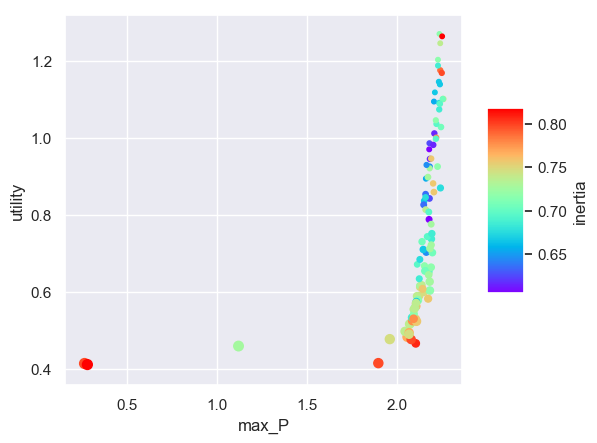

In [13]:
PyRhodium.use_seaborn("darkgrid")
fig = scatter2d(model, output);

Rhodium by default assumes that it should plot the model responses.  These responses are automatically plotted on the x, y, z (for 3D plots), color, and size axes.  This can be customized.  For example, we can color each point with their reliability:

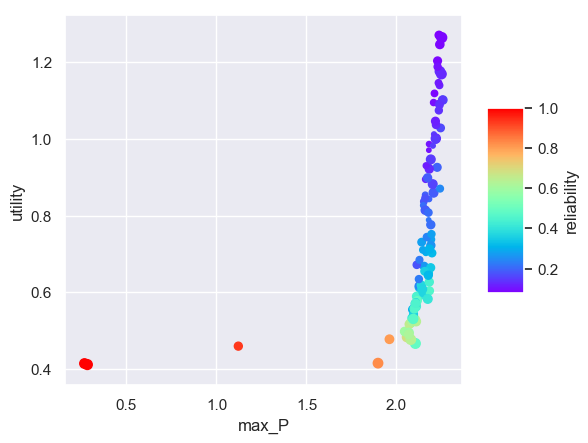

In [14]:
fig = scatter2d(model, output, c="reliability");

It is also possible to group or classify policies together using brushing.  Brushing in Rhodium uses Python expressions to match the policies of interest.  When plotting with brushes, the points will be highlighted if they match the brush:

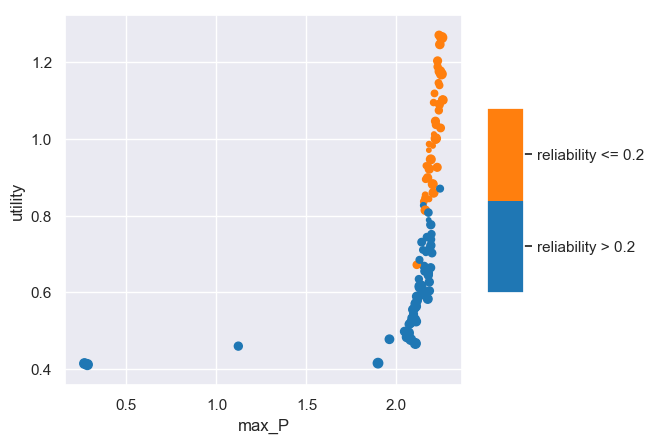

In [15]:
fig = scatter2d(model, output,
                brush=[Brush("reliability > 0.2"), Brush("reliability <= 0.2")]);

Brushing includes several additional options, such as allowing additional control over the plotting (e.g., setting color or point size).  As shown, it is possible to define more than one brush.  Also, any points not painted by a brush will appear as "Unassigned".  

We can similary generate 3D plots in Rhodium:

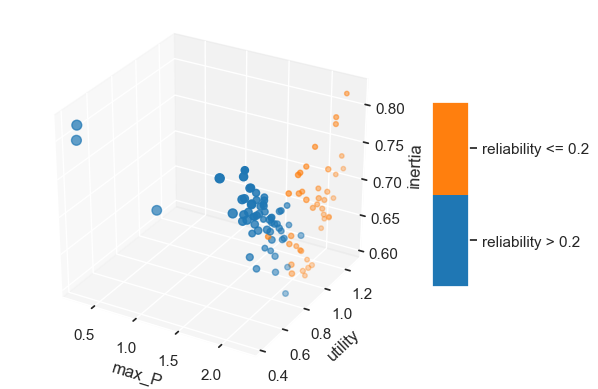

In [16]:
fig = scatter3d(model, output, c="reliability",
                brush=[Brush("reliability > 0.2"), Brush("reliability <= 0.2")]);

2D and 3D scatter plots show the relationships between many factors.  Interpreting the relationships and interactions in a 3D plot can be challenging.  We can simplify the plotting of relationships/interactions by generating pairwise scatter plots:

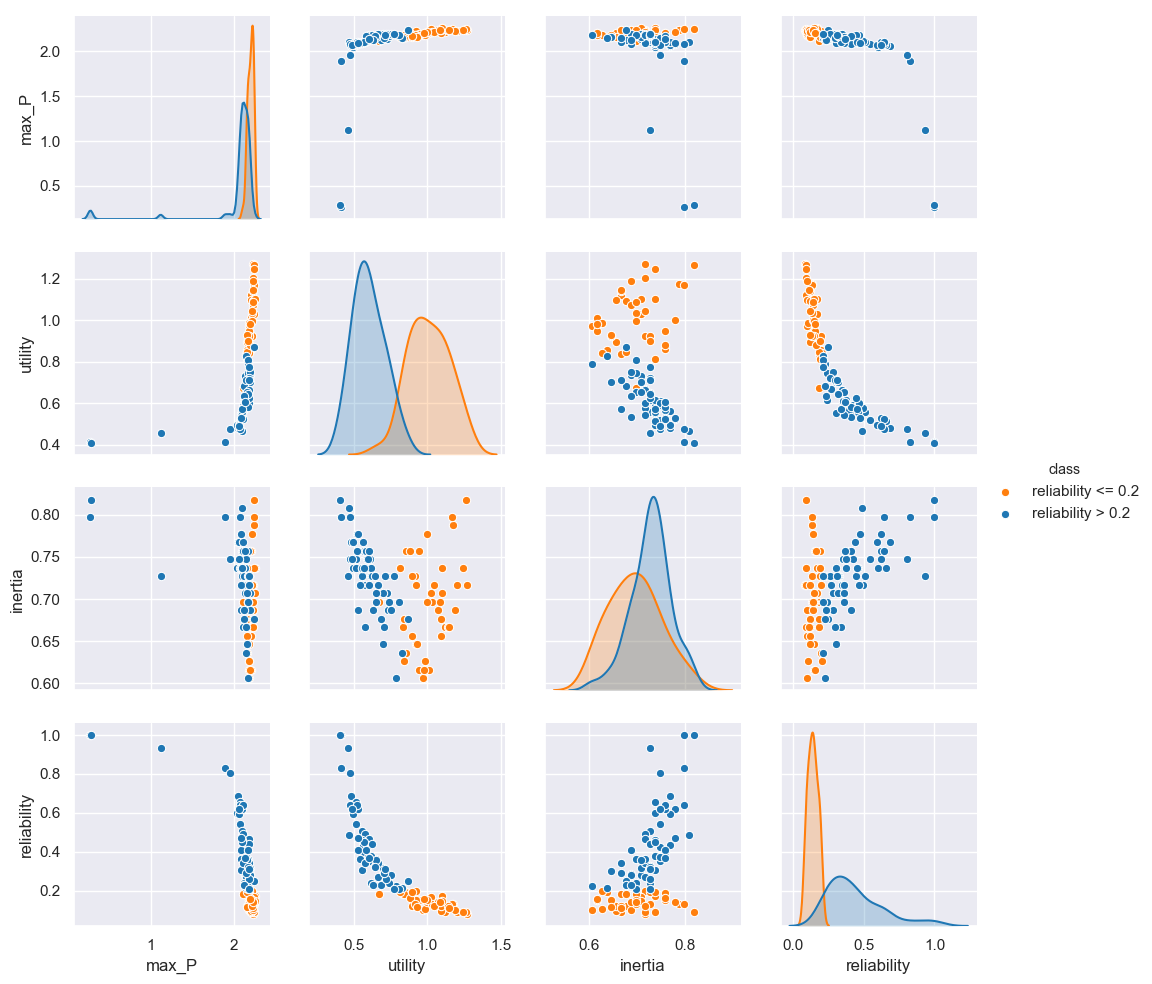

C:\Users\david\.julia\conda\3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [17]:
fig = PyRhodium.pairs(model, output,
            brush=[Brush("reliability > 0.2"), Brush("reliability <= 0.2")]);

Another commonly used way to view interactions between factors is parallel coordinates plots:

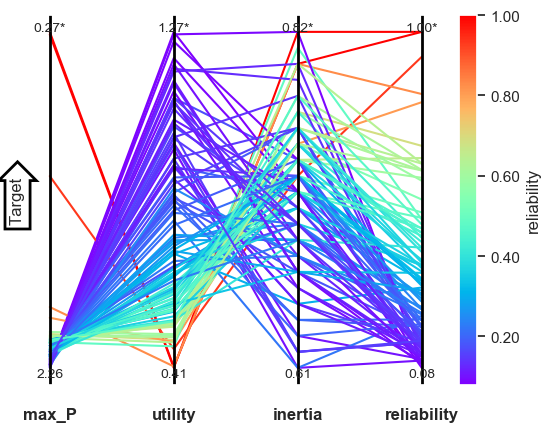

In [18]:
fig = parallel_coordinates(model, output, colormap="rainbow", target="top");

Similar to the other plots, brushing is also supported.

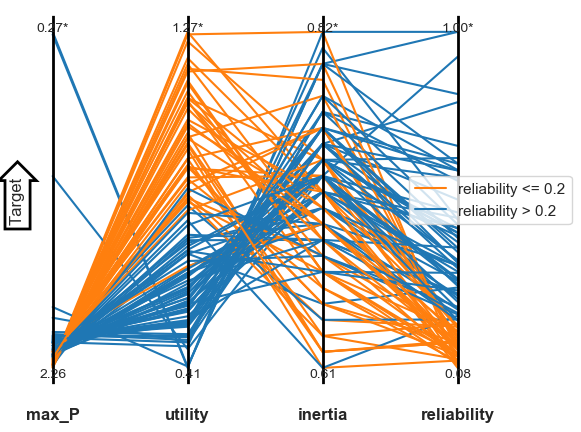

In [19]:
fig = parallel_coordinates(model, output, target="top",
                           brush=[Brush("reliability > 0.2"), Brush("reliability <= 0.2")]);

## Scenario Discovery

Using optimization, we leveraged an automated search procedure to identify optimal policies for our model.  We can also manually explore different policies.  Recall that a policy is simply a Python dictionary with keys mapping to our parameters.  We can construct new policies by creating dictionaries with whatever parameters we wish to control.  For example, here is a policy where we allow a yearly pollution level of 0.02:

In [20]:
policy = Dict("pollution_limit" => fill(0.02, 100))

Dict{String,Array{Float64,1}} with 1 entry:
  "pollution_limit" => [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0…

We can use `evaluate` to evaluate the policy and display the responses:

In [21]:
result = named_tuple(evaluate(model, policy))

println("Max Phosphorus in Lake: ", result.max_P)
println("Utility:                ", result.utility)
println("Inertia:                ", result.inertia)
println("Reliability:            ", result.reliability)

Max Phosphorus in Lake: 0.14324883458361998
Utility:                0.34001313408925654
Inertia:                1.0
Reliability:            1.0000000000000007


When we evaluate the policies in this manner, we are assuming there is no uncertainty.  The default values for each parameter is used in the calculation.  We can also explore the effects of uncertainties on our policy.  First, we must define the uncertain parameters and their distributions.  Below we use uniformly-distributed uncertainties, but other distributions such as normal and log-normal are also supported.

In [22]:
set_uncertainties!(model, [:b => Uniform(0.1, 0.45),
    :q => Uniform(2.0, 4.5),
    :mean => Uniform(0.01, 0.05),
    :stdev => Uniform(0.001, 0.005),
    :delta => Uniform(0.93, 0.99)])

Next, we will create many possible states-of-the-world (SOWs), each representing some combination of the uncertainty parameters.  Here, we generate 1000 SOWs:

In [23]:
SOWs = sample_lhs(model, 1000);

Then, using the `evaluate` method, we evaluate our policy in each SOW.  To do this, we need to combine our SOWs with our fixed policy.  Using the `update` function, we update each SOW with the parameters defined in our policy, namely the fixed `pollution_limit` we specified previously.

In [24]:
results = evaluate(model, [merge(i, policy) for i in SOWs]);

It can be cumbersome to explore the results from the 1000 SOWs separately.  Instead, we are really only interested in SOWs where our policy achieved a reliability of 90% or greater (conversely, we could be interested in SOWs where our system failed with poor reliability).  We "classify" each SOW as "Reliable" or "Unreliable":

In [25]:
classification = apply(results, "'Reliable' if reliability > 0.9 else 'Unreliable'")

1000-element Array{Any,1}:
 "Reliable"  
 "Unreliable"
 "Reliable"  
 "Unreliable"
 "Unreliable"
 "Unreliable"
 "Reliable"  
 "Reliable"  
 "Reliable"  
 "Reliable"  
 "Reliable"  
 "Unreliable"
 "Unreliable"
 ⋮           
 "Reliable"  
 "Reliable"  
 "Unreliable"
 "Reliable"  
 "Unreliable"
 "Unreliable"
 "Unreliable"
 "Reliable"  
 "Reliable"  
 "Unreliable"
 "Reliable"  
 "Reliable"  

Now we will use the Patient Rule Induction Method (PRIM) to identify the key uncertainties that cause a SOW to fall within either class.  This process is termed "scenario discovery".  PRIM works by restricting the dimensions (bounds) for each uncertainty that contains the SOWs of interest.  We refer to these restrictions as a "box".

PRIM is an iterative process.  We call `find_box()` followed by `box.show_tradeoff()` to display visually the dimension restrictions in terms of two metrics: coverage and density.  Coverage measures the percentage of cases of interest contained within the box and density considers the percentage of cases within the box that are of interest.  Having a coverage and density of 100% is ideal.  Note we provide the `coi` argument to indicate we are interested in solutions classified as "Reliable".

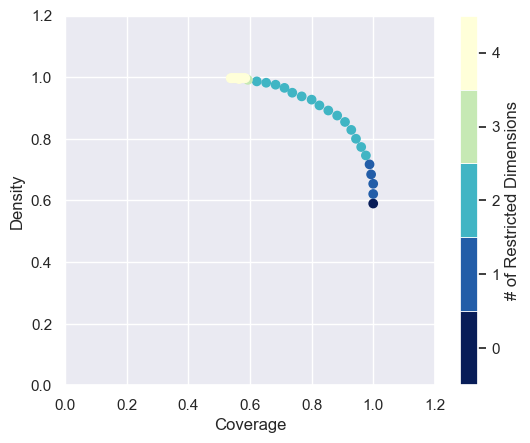

C:\Users\david\.julia\conda\3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


PyObject <Figure size 640x480 with 2 Axes>

In [26]:
uncertainties = [obj.name for obj in model.pyo.uncertainties]

p = Prim(results, classification, include=uncertainties, coi="Reliable")
box = find_box(p)
fig = show_tradeoff(box)

Each point in the above plot represents a sequence of restrictions on the dimensions (a peeling trajectory).  Typically, as we restrict each dimension further, we improve density but reduce coverage.  We can view the details on a specific peeling trajectory by first selecting the i-th trajectory with `box.select(i)` and running:

In [27]:
print(box)

Box 1 [Peeling Trajectory 42]
    Stats
        Coverage: 0.584746
        Density:  0.997110
        Mass:     0.346000
        Res Dim:  4.000000
        Mean:     0.997110
    Limits
                    min       max     qp values
        b      0.251207  0.449772  7.584338e-52
        q      2.800635  4.497860  9.497303e-22
        mean   0.010007  0.049011  2.056303e-01
        stdev  0.001194  0.004997  2.237527e-01

If you're running this example directly from Python, you can also run `box.show_details()` to produce a nicely formatted visual display of the box limits, the covered SOWs, and the box statistics.  See [here](https://github.com/Project-Platypus/PRIM/blob/master/docs/images/screenshot2.png) for an example.

Classification and Regression Trees (CART) is an alternative method for scenario discovery.  Unlike PRIM, which produces a single box containing the cases of interest, CART can form disjoint partitions of the dataset.  As such, it tends to offer better classification rates at the expensive of interpretability (the partitions can become complex and difficult to understand).

In [28]:
c = Cart(results, classification, include=uncertainties, min_samples_leaf=50)

Cart(PyObject <rhodium.classification.Cart object at 0x0000000048142CF8>)

# Note: show_tree requires graphviz

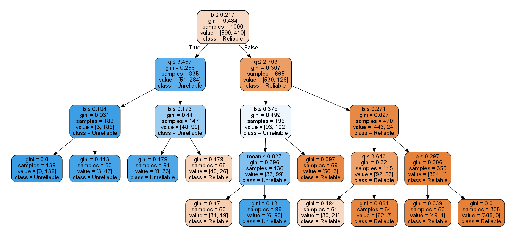

PyObject <matplotlib.image.AxesImage object at 0x0000000046BDC860>

In [29]:
show_tree(c)

The graphic above shows each recursive partition identified by CART, color-coded by their classification.  We can also print the contents of the tree.  If the case of interest (`coi`) is specified, then it prints only those nodes with the given class, letting you compare the density and coverage of a node (including intermediate nodes) as we did with PRIM.  It also prettifies the rules as shown below.

In [30]:
print_tree(c, coi="Reliable")

Node 7: Reliable
    Density: 60.61%
    Coverage: 6.78%
    Rule: 0.172527 <= b <= 0.217255 and
          q > 3.466726
Node 8: Reliable
    Density: 81.05%
    Coverage: 91.36%
    Rule: b > 0.217255
Node 11: Reliable
    Density: 62.00%
    Coverage: 5.25%
    Rule: 0.217255 <= b <= 0.374730 and
          mean <= 0.027368 and
          q <= 2.702832
Node 13: Reliable
    Density: 94.92%
    Coverage: 9.49%
    Rule: b > 0.374730 and
          q <= 2.702832
Node 14: Reliable
    Density: 94.89%
    Coverage: 75.59%
    Rule: b > 0.217255 and
          q > 2.702832
Node 15: Reliable
    Density: 80.00%
    Coverage: 15.59%
    Rule: 0.217255 <= b <= 0.271053 and
          q > 2.702832
Node 16: Reliable
    Density: 58.82%
    Coverage: 5.08%
    Rule: 0.217255 <= b <= 0.271053 and
          2.702832 <= q <= 3.642839
Node 17: Reliable
    Density: 96.88%
    Coverage: 10.51%
    Rule: 0.217255 <= b <= 0.271053 and
          q > 3.642839
Node 18: Reliable
    Density: 99.72%
    Coverage

## Sensitivity Analysis

Rhodium also automates the task of performing global and regional sensitivity analysis on the model uncertainties.  Rhodium provides a convenient wrapper on top of Python's [SALib](https://github.com/SALib/SALib/), allowing you to specify only the model, the response of interest, an optional policy you want to investigate, and details on the sensitivity analysis method.  Lets start with the Morris method to identify the sensitive parameters with respect to reliability:

In [31]:
result = sa(model, "reliability", policy=policy, method="morris", nsamples=1000, num_levels=4, grid_jump=2)
print(result.pyo)

PyObject {'mu': {'b': 0.7595703592814375, 'q': 0.515692814371258, 'mean': -0.2609218562874253, 'stdev': -0.00030449101796409126, 'delta': -0.00017335329341317066}, 'mu_star': {'b': 0.7595703592814375, 'q': 0.515692814371258, 'mean': 0.2609218562874253, 'stdev': 0.0016571856287425236, 'delta': 0.000854191616766467}, 'mu_star_conf': {'b': 0.08832341704263015, 'q': 0.08396382260079992, 'mean': 0.06186692073416019, 'stdev': 0.000829647504752582, 'delta': 0.00043964952866942244}, 'sigma': {'b': 0.5905015673636328, 'q': 0.5536294776584727, 'mean': 0.4126565833711435, 'stdev': 0.00549979141539665, 'delta': 0.0029502949843894636}}

Concurring with the PRIM analysis, parameters `b`, `q`, and `mean` exhibit the largest sensitivites.  Some methods, like the Morris method, only analyze the effects of parameters in isolation.  The Sobol method lets us also compute second-order and total-order indices capturing the interactions between parameters:

In [32]:
result = sa(model, "reliability", policy=policy, method="sobol", nsamples=10000)
print(result.pyo)

PyObject {'S1': {'b': 0.5219998978933855, 'q': 0.23194808534391806, 'mean': 0.08319296847948772, 'stdev': -0.0005526051444133109, 'delta': -0.00013714358126012065}, 'S1_conf': {'b': 0.07902454160979651, 'q': 0.07425546022473159, 'mean': 0.040080721232107916, 'stdev': 0.0005838155328991818, 'delta': 0.0003515272275530538}, 'ST': {'b': 0.7264116118676767, 'q': 0.42146675311473303, 'mean': 0.20456594284260812, 'stdev': 4.7529137322605474e-05, 'delta': 8.167776130285811e-06}, 'ST_conf': {'b': 0.06563609473203284, 'q': 0.055609183380747815, 'mean': 0.03833151808854223, 'stdev': 3.7788927396591736e-05, 'delta': 3.2120722138448e-06}, 'S2': {'b': {'q': 0.05053629813507979, 'mean': 0.00026411594349289025, 'stdev': 0.0014266903111655586, 'delta': 0.0014897936747481821}, 'q': {'b': 0.05053629813507979, 'mean': 0.0011281940678671415, 'stdev': 0.02611023733523092, 'delta': 0.02521208224941206}, 'mean': {'b': 0.00026411594349289025, 'q': 0.0011281940678671415, 'stdev': -0.018868103448969317, 'delta'

We can also visualize the results from sensitivity analysis.  For example, below we plot the first and total-order sensitivity indices for the Sobol method.  Similar 2D bar plots can be shown for all other supported methods.

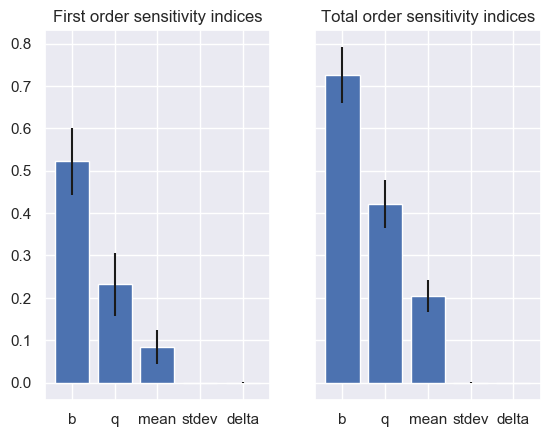

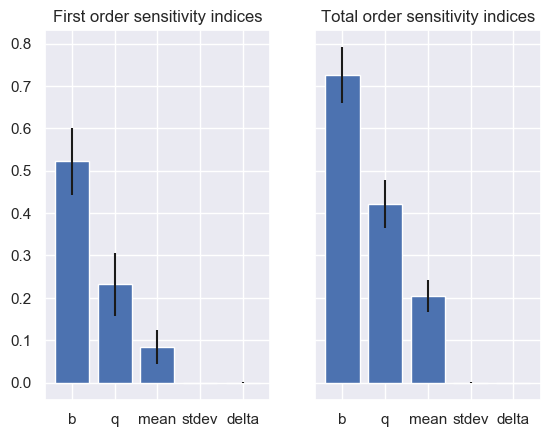

In [33]:
fig = plot(result)

If using Sobol's method, we can also generate a "spider" or "radial" plot showing the second-order indices.  In the figure below, the first and total-order indices for each parameter are indicated by the solid circle and the outer ring, respectively, where a larger radius indicates larger effects.  The gray lines connecting the circles represents the second-order indices, with thicker lines corresponding to larger second-order effects.

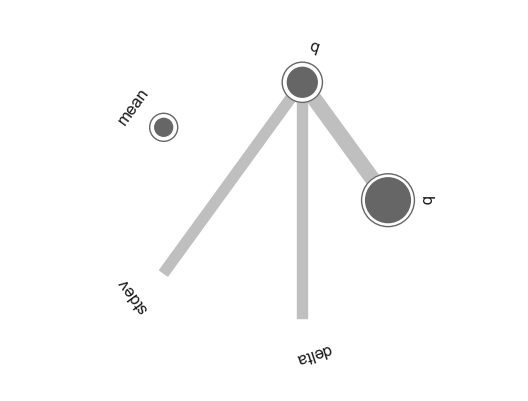

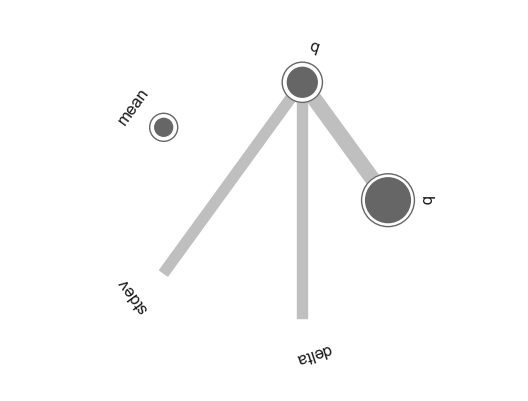

In [34]:
plot_sobol(result, threshold=0.01)

If you have a plot with a large number of parameters, it can be useful to visually group similar parameters.  For example:

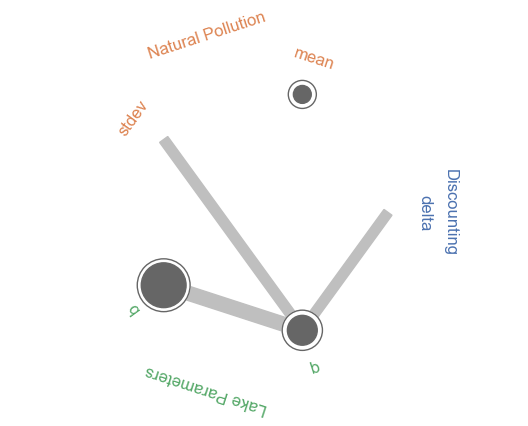

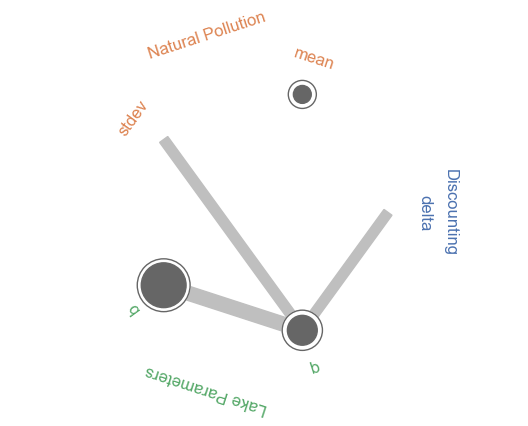

In [35]:
plot_sobol(result, threshold=0.01,
                 groups=Dict("Lake Parameters" => ["b", "q"],
                             "Natural Pollution" => ["mean", "stdev"],
                             "Discounting" => ["delta"]))

Global sensitivity analysis is useful for identifying the key parameters and their interactions.  One limitation is that it does not show where the sensitivities occur.  For example, the analyis above shows that `b`, `q`, and `mean` are the three sensitive parameters, but it doesn't tell us where the parameters are having effect.  We can use one-at-a-time (OAT) or regional sensitivity analysis to explore each parameter in detail.  In OAT sensitivity analysis, we fix all parameters at their default value except one.  For this one parameter, we then sample across its entire range and observe how the response of interest changes.

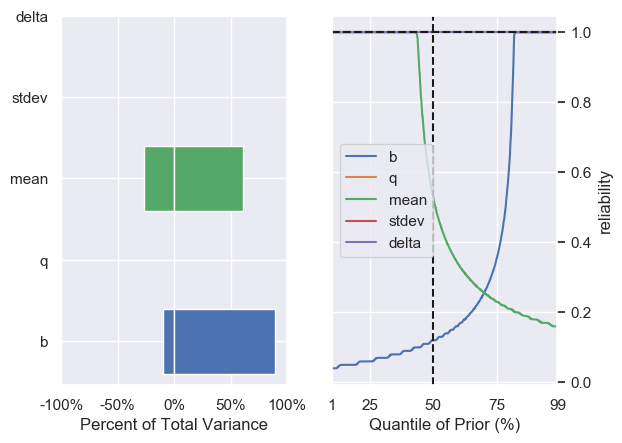

C:\Users\david\.julia\conda\3\lib\site-packages\rhodium\sa.py:456: RuntimeWarning: invalid value encountered in true_divide
  negative_percentage = abs(midv - minv) / total_range
C:\Users\david\.julia\conda\3\lib\site-packages\rhodium\sa.py:457: RuntimeWarning: invalid value encountered in true_divide
  positive_percentage = abs(maxv - midv) / total_range


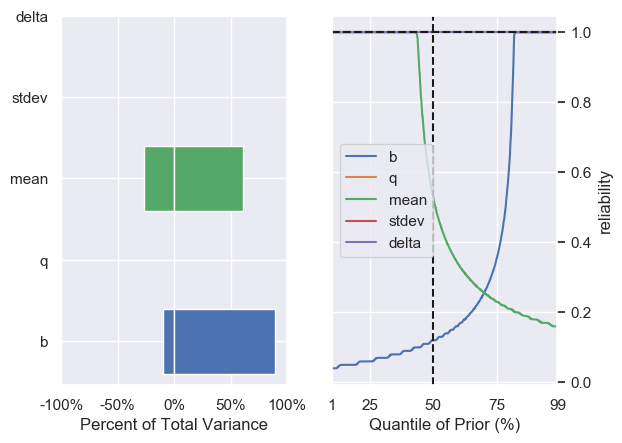

In [36]:
fig = oat(model, "reliability", policy=policy, nsamples=1000)

The plot above shows on the left the percentage of total variance caused by each parameter.  We see that `b` and `q` contribute most to the variance.  On the right we see a line plot showing how the response of interest (reliability) changes as the sampled parameter changes.  Take `b`, for example, shown in blue.  `b` approches 100% reliability as its value increases.  On the other hand, the mean level of pollution, `mean`, causes a substantial reduction in reliability as the value increases.

You may have also noticed that `q` has no effect here, contrary to what we saw from global sensitivity analysis.  Recall that OAT sensitivity analysis fixes all but one parameter at their default value.  This indicates that `q` has little to no effect when the other parameters are fixed at their default.  But since we observed large sensitivites from `q` from global sensitivity analysis, one would expect `q` would become more significant if the other parameters deviate from their default.

## Conclusion

As demonstrated, Rhodium is a powerful tool for analyzing and exploring a model.  We demonstrated connecting Rhodium to a model written in Python.  Rhodium also supports tools for connecting to models written natively (and compiled into a dynamically-linked library or shared object), Excel models, and more.  Please visit our [Github page](https://github.com/Project-Platypus/Rhodium) to learn more.